## **Install dependencies and Setup a Virtual Display**
To generate a replay video of agent and environment.

In [1]:
%%capture
!pip install gym==0.24
!pip install pygame
!pip install numpy
!pip install imageio imageio_ffmpeg

In [2]:
%%capture
!pip install pyglet==1.5.1
!apt install python-opengl
!apt install ffmpeg
!apt install xvfb
!pip3 install pyvirtualdisplay

In [3]:
# Virtual display
from pyvirtualdisplay import Display
virtual_display = Display(visible=0, size=(1400, 900))
virtual_display.start()

## **Import the packages**

In [4]:
import numpy as np
import gym
import random
import imageio
from tqdm.notebook import trange

## **Frozen Lake**

In [5]:
# Create the FrozenLake-v1 environment using 4x4 map and non-slippery version
env = gym.make("FrozenLake-v1",map_name="4x4",is_slippery=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Understanding the FrozenLake environment**

In [6]:
print("_____OBSERVATION SPACE_____ \n")
print("Observation Space:", env.observation_space)
print("Random observation:", env.observation_space.sample())

_____OBSERVATION SPACE_____ 

Observation Space: Discrete(16)
Random observation: 10


In [7]:
print("\n _____ACTION SPACE_____ \n")
print("Action Space Shape:", env.action_space.n)
print("Random action:", env.action_space.sample())


 _____ACTION SPACE_____ 

Action Space Shape: 4
Random action: 1


Actions:
- 0: Move left
- 1: Move down
- 2: Move right
- 3: Move up

Rewards:
- Reach goal: +1
- Reach hole: 0
- Reach frozen: 0

Termination:
- The player moves into a hole.
- The player reaches the goal

## **Create and Initialize the Q-table**

In [8]:
state_space = env.observation_space.n
action_space = env.action_space.n
print("There are ", state_space, " possible states")
print("There are ", action_space, " possible actions")

There are  16  possible states
There are  4  possible actions


In [9]:
# Create Qtable of size (state_space, action_space) and initialized each values at 0 using np.zeros
def initialize_q_table(state_space, action_space):
  Qtable = np.zeros((state_space, action_space))
  return Qtable

In [10]:
Qtable_frozenlake = initialize_q_table(state_space, action_space)

## **Define the epsilon-greedy policy**

In [11]:
def epsilon_greedy_policy(Qtable, state, epsilon):
  # Randomly generate a number between 0 and 1
  random_int = random.uniform(0,1)
  if random_int > epsilon:
    action = np.argmax(Qtable[state])
  else:
    action = env.action_space.sample()
  return action

## **Define the greedy policy**

In [12]:
def greedy_policy(Qtable, state):
  # Exploitation: take the action with the highest state, action value
  action = np.argmax(Qtable[state])
  return action

## **Define the hyperparameters**

In [13]:
# Training parameters
n_training_episodes = 10000
learning_rate = 0.7

# Evaluation parameters
n_eval_episodes = 100

# Environment parameters
env_id = "FrozenLake-v1"
max_steps = 99
gamma = 0.95
eval_seed = []

# Exploration parameters
max_epsilon = 1.0
min_epsilon = 0.05
decay_rate = 0.0005

## **Training the model**

In [14]:
def train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable):
  for episode in trange(n_training_episodes):
    # Reduce epsilon
    epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode)
    # Reset the environment
    state = env.reset()
    step = 0
    done = False

    for step in range(max_steps):
      # Choose the action At using epsilon greedy policy
      action = epsilon_greedy_policy(Qtable, state, epsilon)

      # Take action At and observe Rt+1 and St+1
      # Take the action (a) and observe the outcome state(s') and reward (r)
      new_state, reward, done, info = env.step(action)

      # Update Q(s,a):= Q(s,a) + lr [R(s,a) + gamma * max Q(s',a') - Q(s,a)]
      Qtable[state][action] = Qtable[state][action] + learning_rate * (reward + gamma * np.max(Qtable[new_state]) - Qtable[state][action])

      # If done, finish the episode
      if done:
        break

      # Our state is the new state
      state = new_state
  return Qtable

In [15]:
Qtable_frozenlake = train(n_training_episodes, min_epsilon, max_epsilon, decay_rate, env, max_steps, Qtable_frozenlake)

  0%|          | 0/10000 [00:00<?, ?it/s]

## **Tranined Q-Learning table**

In [16]:
Qtable_frozenlake

array([[0.73509189, 0.77378094, 0.77378094, 0.73509189],
       [0.73509189, 0.        , 0.81450625, 0.77378094],
       [0.77378094, 0.857375  , 0.77378094, 0.81450625],
       [0.81450625, 0.        , 0.77378094, 0.77378094],
       [0.77378094, 0.81450625, 0.        , 0.73509189],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.        , 0.81450625],
       [0.        , 0.        , 0.        , 0.        ],
       [0.81450625, 0.        , 0.857375  , 0.77378094],
       [0.81450625, 0.9025    , 0.9025    , 0.        ],
       [0.857375  , 0.95      , 0.        , 0.857375  ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.9025    , 0.95      , 0.857375  ],
       [0.9025    , 0.95      , 1.        , 0.9025    ],
       [0.        , 0.        , 0.        , 0.        ]])

In [17]:
import pandas as pd
import pandas as pd
q_df = pd.DataFrame(np.round(Qtable_frozenlake, 3), columns=["LEFT", "DOWN", "RIGHT", "UP"])
q_df

,LEFT,DOWN,RIGHT,UP
0,0.735,0.774,0.774,0.735
1,0.735,0.000,0.815,0.774
2,0.774,0.857,0.774,0.815
3,0.815,0.000,0.774,0.774
4,0.774,0.815,0.000,0.735
5,0.000,0.000,0.000,0.000
6,0.000,0.902,0.000,0.815
7,0.000,0.000,0.000,0.000
8,0.815,0.000,0.857,0.774
9,0.815,0.902,0.902,0.000


## **Model evaluation**

In [18]:
def evaluate_agent(env, max_steps, n_eval_episodes, Q, seed):
  """
  Evaluate the agent for ``n_eval_episodes`` episodes and returns average reward and std of reward.
  :param env: The evaluation environment
  :param n_eval_episodes: Number of episode to evaluate the agent
  :param Q: The Q-table
  :param seed: The evaluation seed array (for taxi-v3)
  """
  episode_rewards = []
  for episode in range(n_eval_episodes):
    if seed:
      state = env.reset(seed=seed[episode])
    else:
      state = env.reset()
    step = 0
    done = False
    total_rewards_ep = 0

    for step in range(max_steps):
      # Take the action (index) that have the maximum expected future reward given that state
      action = np.argmax(Q[state][:])
      new_state, reward, done, info = env.step(action)
      total_rewards_ep += reward

      if done:
        break
      state = new_state
    episode_rewards.append(total_rewards_ep)
  mean_reward = np.mean(episode_rewards)
  std_reward = np.std(episode_rewards)

  return mean_reward, std_reward

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
# Evaluate our Agent
mean_reward, std_reward = evaluate_agent(env, max_steps, n_eval_episodes, Qtable_frozenlake, eval_seed)
print(f"Mean_reward={mean_reward:.2f} +/- {std_reward:.2f}")

Mean_reward=1.00 +/- 0.00


## **Visualizing the results**

In [20]:
def record_video(env, Qtable, out_directory, duration=1000):
  images = []
  done = False
  state = env.reset(seed=random.randint(0,500))
  img = env.render(mode='rgb_array')
  images.append(img)
  while not done:
    # Take the action (index) that have the maximum expected future reward given that state
    action = np.argmax(Qtable[state][:])
    state, reward, done, info = env.step(action) # We directly put next_state = state for recording logic
    img = env.render(mode='rgb_array')
    images.append(img)
  imageio.mimsave(out_directory, [np.array(img) for i, img in enumerate(images)], duration=duration)

Saving animated file as gif with 1 frame per second

In [21]:
video_path="/content/replay.gif"
video_duration = 1000

In [22]:
record_video(env, Qtable_frozenlake, video_path, video_duration)

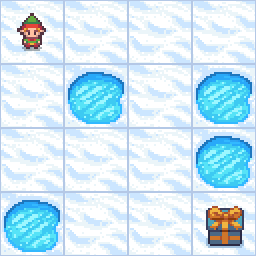

In [23]:
from IPython.display import Image
Image('./replay.gif')